# <center>  Python for biologists
    
## Homework 12, Data analysis



### Правила

- Не создавайте доп. веток в репозитории, не копируйте ноутбук.
- Пишите код только там, где это от вас требуется (`# YOUR CODE HERE`)
- Используйте разобранный нами функционал, решения через циклы, `Counter` и т.п. засчитываться не будут.
- Перед отправкой проверьте что ваш ноутбук работает (юпитер-ноутбук). Нажмите на панели сверху `Kernel` -> `Restart Kernel and Run All Cells...`. Проверье что нет ошибок.
    

#### Погнали!

---


In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from scipy.stats import mannwhitneyu

# здесь любые импорты которые вам еще понадобятся (только здесь)

# Продвинутая работа с одним дата-фреймом  </br> на примере биомедицинских данных

Мы будем работать с фармакокинетическим Варифариновым датасетом `warfarin.csv` (конкретный пример взят [отсюда](https://insightrx.github.io/PKPDsim/reference/pkdata.html?q=pkdata), но почитать можно [тут](https://dataset.lixoft.com/data-set-examples/warfarin-data-set/) и [тут](https://ascpt.onlinelibrary.wiley.com/doi/10.1038/clpt.2010.37/)).

Датасет содержит следующие колонки:
- `ID` - Идентификатор пациента
- `Time` - Время внесения записи
- `WT` - Вес пациента
- `AGE` - Возраст пациента
- `SEX` - Пол пациента
- `CRCL` - Клиренс креатинина пациента (показатель работоспособности почек)
- `EVID` - Event ID - флаг который обозначает тип события: 1 - администрирование (введение) дозы варфарина, 0 - запись концентрации варфарина в крови
- `AMT` - Amount, Доза варфарина которая была дана пациенту
- `DV` - Зависимая переменная в анализе, концентрация варфарина в крови

Соотвественно про данные история такая, что не может быть одновременной записи DV и AMT. Мы либо даем дозу, либо измеряем концентрацию - не одновременно. Это и обозначает флаг EVID.  Поэтому если в DV стоит 0 - это не значит что концентрация 0, скорее всего эта запись отмечена флагом EVID 1, то мы и не знаем концентрацию, мы её не измеряли.




In [8]:
warfarin = pd.read_csv('data/warfarin.csv', sep='\t')

### Задание 1 📈

Сколько в среднем имеется записей на пациента?


*(0.5 балла)*

In [9]:
result = warfarin['ID'].value_counts().mean()

In [10]:
assert result == 13.0

### Задание 2 📈

Выведите средний возраст всех пациентов.


*(0.5 балла)*

In [11]:
result = warfarin['AGE'].mean()

In [12]:
assert np.isclose(result, 53.0883, atol=1e-3)

### Задание 3 📈

Выведите в виде списка имена колонок, где у каждого пациента значения не меняются


*(0.5 балла)*

In [13]:
result = [col for col in warfarin.columns if warfarin.groupby('ID')[col].nunique().max() == 1 and col != 'ID']

In [14]:
assert result == ['WT', 'CRCL', 'AGE', 'SEX']

### Задание 4 📈

Постройте [Spaghetti plot](https://en.wikipedia.org/wiki/Spaghetti_plot) DV vs TIME по каждому ID, отметьте вертикальными линиями моменты времени когда вводилась доза. Референсный график приеден в файле `spaghetti_plot.png`.  Обратите внимание, что на референсе `DV` не "проваливается" до 0. Почему?

На графике DV не "проваливается" до 0, поскольку мы исключили записи, где вводилась доза, а не измерялась концентрация варфарина. Это соответствует логике, что когда вводится доза, концентрация варфарина не измеряется, и поэтому для этих моментов нет значений DV.

*(1.5 балла)*

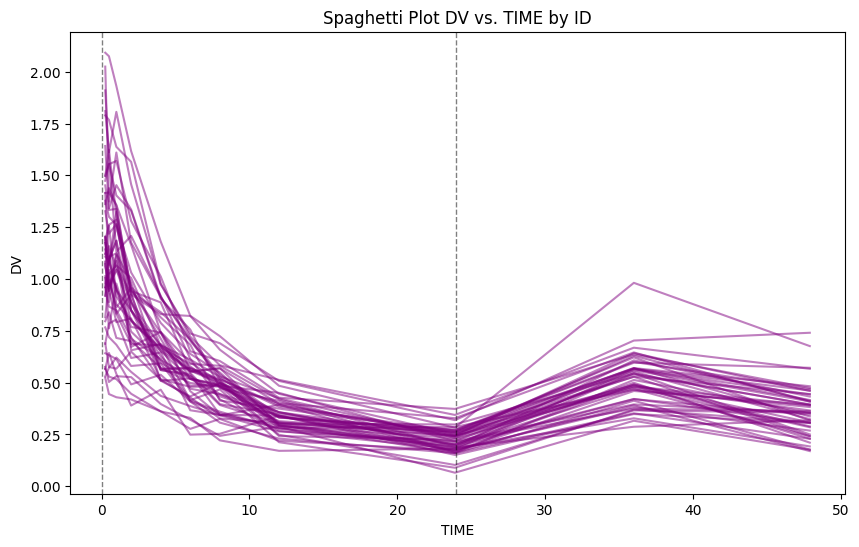

In [15]:
# Фильтрация данных, чтобы исключить записи с введением дозы
dv_time_data = warfarin[warfarin['EVID'] == 0]
# Получение уникальных временных точек введения дозы
dose_times = warfarin[warfarin['EVID'] == 1]['TIME'].unique()
# Построение Spaghetti plot
plt.figure(figsize=(10,6))
for pid, group in dv_time_data.groupby('ID'):
    plt.plot(group['TIME'], group['DV'], color='purple', alpha=0.5)
# Добавление вертикальных линий для времен введения доз
for time in dose_times:
    plt.axvline(x=time, color='black', linestyle='--', lw=1, alpha=0.5)
plt.title('Spaghetti Plot DV vs. TIME by ID')
plt.xlabel('TIME')
plt.ylabel('DV')
plt.show()

Вот другой вариант, цветным мне нравится больше

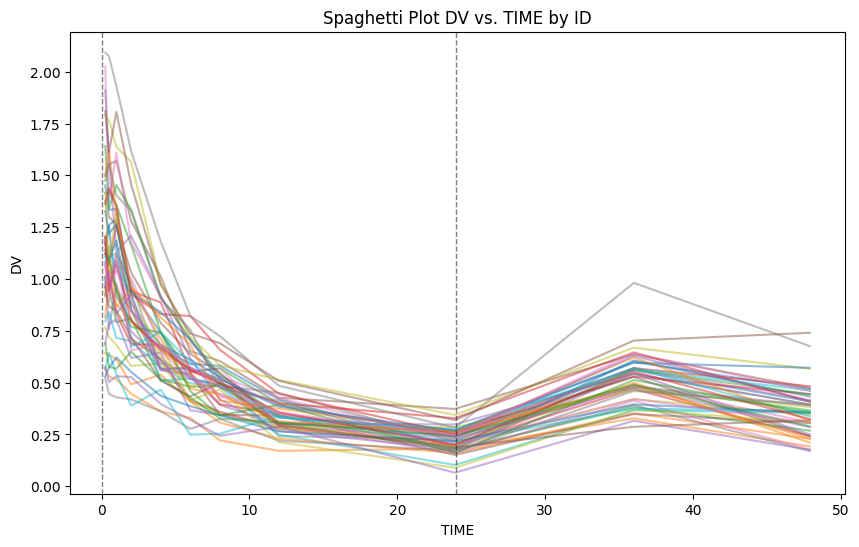

In [16]:
# Фильтрация данных, чтобы исключить записи с введением дозы
dv_time_data = warfarin[warfarin['EVID'] == 0]
# Получение уникальных временных точек введения дозы
dose_times = warfarin[warfarin['EVID'] == 1]['TIME'].unique()
# Построение Spaghetti plot
plt.figure(figsize=(10,6))
for pid, group in dv_time_data.groupby('ID'):
    plt.plot(group['TIME'], group['DV'], alpha=0.5)
# Добавление вертикальных линий для времен введения доз
for time in dose_times:
    plt.axvline(x=time, color='black', linestyle='--', lw=1, alpha=0.5)
plt.title('Spaghetti Plot DV vs. TIME by ID')
plt.xlabel('TIME')
plt.ylabel('DV')
plt.show()

> Ну а далее ученые-фармакометрики строят по этим графикам математические модели (нелинейные) чтобы уметь описывать фармакокинетический профиль концентрации лекарства в крови, учитывать влияние пола / веса / генотипа / ... человека, и в конце-концов, предсказывать ту самую оптимальную дозу для конкретного пациента. Таргетная терапия! Но это уже совсем другая история.

# Продвинутая работа с несколькими дата-фреймами  </br> на примере биоинформатических данных

Мы будем работать со следующими омиксными данными:
- RNA-seq малых РНК из нейронов здорового человека и пациента с некоторым нейродегенеративным заболеванием
- ChIP-seq'и за белки 'CTCF' и 'SMC3' (они в том числе отвечают за структуру хроматина и экспрессию генов)



### Задание 6 📈 Подготовка данных


##### 1) Прочитайте данные в 3 датафрема `ctcf`, `smc3` и `rnaseq`. Для этого вам понадобится:
- Понять названия колонок (про форматы данных можно почитать [тут](https://genome.ucsc.edu/FAQ/FAQformat.html))
- Понять как прочитать BigWig данные (они бинарные). Существует библиотека `pyBigWig`, но она хранит датасеты в очень странном фармате, в данной домашке ЗАПРЕЩАЕТСЯ её использовать. Сконвертируйте в коммандной строке BigWig в bedGraph и читайте bedGraph в pandas-dataframe.
- Прочитав два дата-фрейма для РНК-сека вам нужно объединить их в один дата-фрейм добавив колонку обозначающую тип образца



##### 2) Создайте датафрейм с аннотацией генома человека версии GRCh38.p13. Для этого вам понадобится:
- Найти эту аннотацию. Я советую формат `gff3`.
- Файл будет очень большой, советую предобработать его в командной строке:
    - Отобрать только нужные колонки
    - Отобрать только записи соответвующие генам
    - (Если компьютер слабый) отобрать только записи соответствующие 15 хромосоме.
- Прочитать это дело в pandas-data frame
- Имя гена находится в последней колонке gff3, где много полей аггрегированы через `;`. Вам нужно:
    - Найти как называется нужное поле, где лежит имя гена.
    - Достать имя гена в отдельную колонку (например `gene` или `gene_name`). </br>
    Достать имя гена может быть не очень тривиально. Можно сделать это в баше, можно сделать это в питоне. Тут на ваше усмотрение. В питоне по-сути у вас есть колонка с кучей информации в виде строки откуда вам нужно что-то достать. Ровно для этого мы и разобрали [ацессор `str`](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html)! Могу предложить 2 пути:
        - (Попродвинутее)  Используйте `str.replace` с параметром `regex=True`. Не зря же мы учили регексы!
        - (Попроще) Используйте `str.split` чтобы отрезать ненужное и вырезать нужное
        
        
##### 3) Во всех датафреймах оставьте только нужные колонки
    Это колонки с хромосомой, координатами начала и конца, цепью +/-, значением сигнала (для ChIP-seq и RNA-seq) и именем гена (для аннотации)


> Да, обрабатывать готовые данные в питоне легко, но перед любым анализом всегда есть мучительный процесс поиска и подготовки.  Ведь реальный анализ всегда начинается с этого. Теперь вы будете во всеоружии!:)

*(1.5 балла)*

In [97]:
path_ctcf = 'data/CTCF_neurons.bigNarrowPeak'
path_smc3 = 'data/SMC3_neurons.bigNarrowPeak'
path_rnaseq_healthy = 'data/SmallRNAseq_health.bedGraph'
path_rnaseq_disease = 'data/SmallRNAseq_desease.bedGraph'
path_genes = 'data/GRCh38.p13.chr15.genes.gff3'
# Чтение данных CTCF и SMC3
ctcf = pd.read_csv(path_ctcf, sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak'])
smc3 = pd.read_csv(path_smc3, sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak'])
# Фильтрация нужных колонок
ctcf = ctcf[['chrom', 'start', 'end', 'signalValue']]
smc3 = smc3[['chrom', 'start', 'end', 'signalValue']]
# Чтение данных RNA-seq
rnaseq_healthy = pd.read_csv(path_rnaseq_healthy, sep='\t', header=None, names=['chrom', 'start', 'end', 'signal'])
rnaseq_disease = pd.read_csv(path_rnaseq_disease, sep='\t', header=None, names=['chrom', 'start', 'end', 'signal'])
# Добавление колонки обозначающей тип образца и объединение
rnaseq_healthy['sample_type'] = 'healthy'
rnaseq_disease['sample_type'] = 'disease'
rnaseq = pd.concat([rnaseq_healthy, rnaseq_disease])
# Чтение данных аннотации генома и извлечение имени гена
genes = pd.read_csv(path_genes, sep='\t', header=None, comment='#', names=['chrom', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
def extract_gene_name(attribute):
    if not isinstance(attribute, str):
        return 'NA'
    attributes = dict(item.split('=') for item in attribute.split(';') if '=' in item)
    return attributes.get('Name', 'NA')
genes['gene_name'] = genes['attributes'].apply(extract_gene_name)
genes = genes[['chrom', 'start', 'end', 'gene_name']].copy()
genes.loc[:, 'chrom'] = genes['chrom'].astype(str)
print(genes)
print(ctcf)
print(smc3)
print(rnaseq)

       chrom      start        end        gene_name
0         15          1  101991189               NA
1         15   19878555   19887814               NA
2         15   19878555   19887814               NA
3         15   19878555   19878668  ENSE00002133693
4         15   19878831   19879004  ENSE00003544224
...      ...        ...        ...              ...
120313    15  101980167  101980172               NA
120314    15  101980190  101980196               NA
120315    15  101980195  101980202               NA
120316    15  101980224  101980227               NA
120317    15  101980226  101980229               NA

[120318 rows x 4 columns]
       chrom      start        end  signalValue
0      chr10    6088493    6089338   6159.99256
1      chr16    2340402    2341333   5220.13328
2      chr17   43483394   43484133   5213.66631
3       chrX   10119250   10120118   4732.73890
4      chr20   31612643   31613371   4692.83895
...      ...        ...        ...          ...
51674  chr17 

### Задание 7 📈 Аннотация

1) Возьмите данные ChIP-seq и аннотацию. Для экономии ресурсов отберите только 15 хромосому.
2) Смерджте дата-фреймы ChIP-seq так чтобы получить набор только пересекающихся пиков
3) Обработайте смердженный датафрейм:
    - Создайте колонки `start` и `stop` которые будут отмечать координаты объединения двух пиков (то есть самое левое начало и самый правый конец)
    - Отберите топ 100 записей по суммарной интенсивности сигналов CTCF и SMC3
    - Отберите только нужные колонки: хромосома, `start` и `stop`, интенсивности сигналов
    
    </br>

4) Добавьте аннотацию.
    - Смерджьте датафрейм пиков с датафремом аннотации.
    - Отберите только те пики, которые покрывают НАЧАЛО какого-то гена (т.к. регуляция экспрессии обычно происходит в начале гена, нам интересно посмотреть на началах каких генов сидят CTCF и SMC3
    - Напечатайте этот датафрейм.

    </br>

5) Биоинформатика... </br>
    А теперь, если бы это были ваши данные, вы бы пошли гуглить, что же за гены оказались потенциально под очень сильным влиянием одновременно и CTCF и SMC3. Но это уже совсем другая история.


*(3 балла)*

In [111]:
# Отбор данных только для 15-й хромосомы
ctcf_chr15 = ctcf[ctcf['chrom'] == 'chr15']
smc3_chr15 = smc3[smc3['chrom'] == 'chr15']
print(ctcf_chr15)
print(smc3_chr15)
genes_chr15 = genes
print(genes_chr15)
# Определение функции is_overlap для проверки пересечения интервалов
def is_overlap(start1, end1, start2, end2):
    return max(start1, start2) < min(end1, end2)
# Применение функции is_overlap для поиска пересекающихся пиков
overlap_df_chr15 = pd.DataFrame(columns=['chrom', 'start_ctcf', 'end_ctcf', 'signalValue_ctcf', 'start_smc3', 'end_smc3', 'signalValue_smc3'])
for index_ctcf, row_ctcf in ctcf_chr15.iterrows():
    for index_smc3, row_smc3 in smc3_chr15.iterrows():
        if row_ctcf['chrom'] == row_smc3['chrom'] and is_overlap(row_ctcf['start'], row_ctcf['end'], row_smc3['start'], row_smc3['end']):
            overlap_df_chr15 = overlap_df_chr15.append({
                'chrom': row_ctcf['chrom'],
                'start_ctcf': row_ctcf['start'],
                'end_ctcf': row_ctcf['end'],
                'signalValue_ctcf': row_ctcf['signalValue'],
                'start_smc3': row_smc3['start'],
                'end_smc3': row_smc3['end'],
                'signalValue_smc3': row_smc3['signalValue']
            }, ignore_index=True)
# Вычисление начала и конца объединённых пиков
overlap_df_chr15['start'] = overlap_df_chr15[['start_ctcf', 'start_smc3']].max(axis=1)
overlap_df_chr15['stop'] = overlap_df_chr15[['end_ctcf', 'end_smc3']].min(axis=1)
# Отбор топ-100 записей по суммарной интенсивности сигналов
overlap_df_chr15['total_signal'] = overlap_df_chr15['signalValue_ctcf'] + overlap_df_chr15['signalValue_smc3']
top_overlap_df_chr15 = overlap_df_chr15.nlargest(10, 'total_signal')  # Возьмем топ-10 для примера
# Отбор только нужных колонок
top_overlap_df_chr15 = top_overlap_df_chr15[['chrom', 'start', 'stop', 'signalValue_ctcf', 'signalValue_smc3']]
top_overlap_df_chr15

       chrom     start       end  signalValue
46     chr15  94119743  94120463   3233.46336
148    chr15  73636263  73636989   2461.49344
181    chr15  82530397  82531221   2349.72643
192    chr15  89358444  89359341   2314.64861
204    chr15  45117940  45118654   2287.08549
...      ...       ...       ...          ...
51481  chr15  48084999  48085466     11.10944
51562  chr15  52171515  52172019     10.77565
51577  chr15  62706513  62707017     10.69373
51608  chr15  73633783  73634287     10.57806
51649  chr15  62549517  62550021     10.41917

[1701 rows x 4 columns]
       chrom     start       end  signalValue
18     chr15  94119665  94120444   2578.95953
106    chr15  74322342  74323116   1885.12418
113    chr15  89358476  89359339   1872.94416
209    chr15  74127354  74128149   1681.18128
228    chr15  79380901  79381570   1653.94343
...      ...       ...       ...          ...
49849  chr15  48352461  48352853     13.12369
49855  chr15  56919602  56920132     13.10301
49881  ch

<ipython-input-111-3a290fcb68a8>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_df_chr15 = overlap_df_chr15.append({
<ipython-input-111-3a290fcb68a8>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_df_chr15 = overlap_df_chr15.append({
<ipython-input-111-3a290fcb68a8>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_df_chr15 = overlap_df_chr15.append({
<ipython-input-111-3a290fcb68a8>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_df_chr15 = overlap_df_chr15.append({
<ipython-input-111-3a290fcb68a8>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

,chrom,start,stop,signalValue_ctcf,signalValue_smc3
0,chr15,94119743.0,94120444.0,3233.46336,2578.95953
3,chr15,89358476.0,89359339.0,2314.64861,1872.94416
1,chr15,73636352.0,73636944.0,2461.49344,1284.01270
21,chr15,74322403.0,74323106.0,1734.20876,1885.12418
6,chr15,40903874.0,40904510.0,2265.74586,1323.44117
15,chr15,74127354.0,74128023.0,1796.95830,1681.18128
2,chr15,82530407.0,82531117.0,2349.72643,1089.69009
9,chr15,92808986.0,92809603.0,2104.90374,1303.36117
7,chr15,77633243.0,77633995.0,2142.06780,1139.82678
22,chr15,65318704.0,65319331.0,1725.80137,1543.00284


from matplotlib import pyplot as plt
top_overlap_df_chr15['start'].plot(kind='hist', bins=20, title='start')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15['stop'].plot(kind='hist', bins=20, title='stop')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15['signalValue_ctcf'].plot(kind='hist', bins=20, title='signalValue_ctcf')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15['signalValue_smc3'].plot(kind='hist', bins=20, title='signalValue_smc3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15.plot(kind='scatter', x='start', y='stop', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15.plot(kind='scatter', x='stop', y='signalValue_ctcf', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15.plot(kind='scatter', x='signalValue_ctcf', y='signalValue_smc3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15['start'].plot(kind='line', figsize=(8, 4), title='start')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15['stop'].plot(kind='line', figsize=(8, 4), title='stop')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15['signalValue_ctcf'].plot(kind='line', figsize=(8, 4), title='signalValue_ctcf')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
top_overlap_df_chr15['signalValue_smc3'].plot(kind='line', figsize=(8, 4), title='signalValue_smc3')
plt.gca().spines[['top', 'right']].set_visible(False)

### Задание 8 📈 Статистическое сравнение данных

 Данные у вас хранятся в агрегированном виде (координаты сжаты до начал и концов интервалов). В связи с этим невозможно делать статистическое сравнение сигналов, так как, условно, какой-то сигнал задан на интервале в 100 п.н., а какой-то в 1000 п.н.. Поэтому данные придется немного предобработать.

1) Возьмите данные RNA-seq. Для экономии ресурсов отберите только 15 хромосому.
2) Переведите датафрейм `['chr', 'start', 'stop', 'signalValue']` в `['chr', 'pos', 'signalValue']`, то есть чтобы у вас каждая позиция была записана в явном виде.

Было:
```python
start stop signal
1     2    10
4     6    100
```
Стало:
```python
pos signal
1    10
2    10
4    100
5    100
6    100
```

Сделать можно разными путями. Я могу посоветовать например [такое](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html). Для этого нужно иметь одну колонку где все нужные координаты из интервала будут записаны в виде списка (все, а не только начало и конец). Я думаю, что проще всего это будет сделать с помощью `apply` (мы же умеем применять его к строкам) и старого доброго `range` :)


3) Статистически интенсивности сигналов РНК-сека на хромосоме 15 между двумя группами образцов. Следите чтобы ваши выводы были корректными.

#### Самый главный график

4) Нарисуйте 2 боксполта интенсивностей сигналов РНК-сека (в log-шкале по y) и проаннотируйте над ними p-value. Если вызывает трудности, начните [отсюда](https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values). Можете найти референс в файле `boxplot.png`


*(2.5 балла)*

        chrom        pos   signal sample_type
0       chr15   19921192  0.01569     healthy
1       chr15   19921193  0.01569     healthy
2       chr15   19921194  0.01569     healthy
3       chr15   19921195  0.01569     healthy
4       chr15   19921196  0.01569     healthy
...       ...        ...      ...         ...
242679  chr15  101981185  0.04708     disease
242680  chr15  101981186  0.04708     disease
242681  chr15  101981187  0.04708     disease
242682  chr15  101981187  0.03139     disease
242683  chr15  101981188  0.03139     disease

[242684 rows x 4 columns]


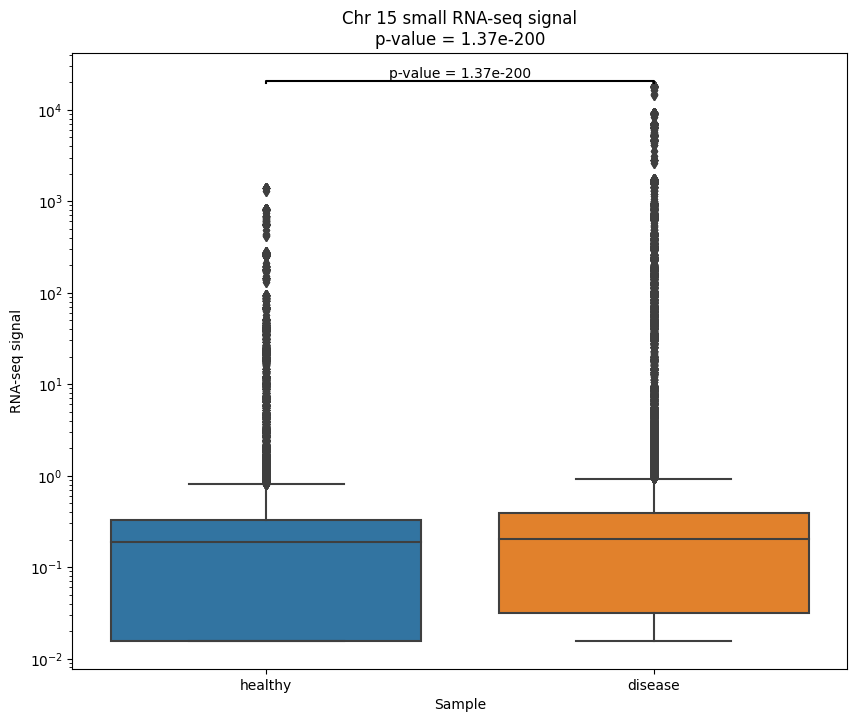

In [124]:
rnaseq_chr15 = rnaseq[rnaseq['chrom'] == 'chr15']
rnaseq_chr15
# Используем apply для создания списка всех позиций в интервалах
expanded_rnaseq = rnaseq_chr15.apply(
    lambda row: pd.Series({'chrom': row['chrom'],
                           'pos': list(range(row['start'], row['end'] + 1)),
                           'signal': row['signal'],
                           'sample_type': row['sample_type']}), axis=1)
# Преобразуем список позиций в отдельные строки
rnaseq_expanded = expanded_rnaseq.explode('pos')
rnaseq_expanded.reset_index(drop=True, inplace=True)
print(rnaseq_expanded)
# Группировка данных по типу образца и подсчет статистики для каждой позиции
healthy_signals = rnaseq_expanded[rnaseq_expanded['sample_type'] == 'healthy']['signal']
disease_signals = rnaseq_expanded[rnaseq_expanded['sample_type'] == 'disease']['signal']
# Проведение теста Манна-Уитни
u_statistic, p_value = mannwhitneyu(healthy_signals, disease_signals, alternative='two-sided')
u_statistic, p_value
# Устанавливаем размер графика
plt.figure(figsize=(10, 8))
# Создаем боксплот с использованием seaborn и отображаем аутлаеры
ax = sns.boxplot(x='sample_type', y='signal', data=rnaseq_expanded)
# Устанавливаем шкалу Y в логарифмическую
plt.yscale('log')
# Аннотация p-value
p_value = 1.3698698588924162e-200  # Результат вашего теста Манна-Уитни
plt.title(f'Chr 15 small RNA-seq signal\np-value = {p_value:.2e}')
# Названия осей
plt.xlabel('Sample')
plt.ylabel('RNA-seq signal')
# Вычисляем координаты для аннотации p-value
x1, x2 = 0, 1  # Позиции для групп "healthy" и "disease" на графике
y = rnaseq_expanded['signal'].max() * 1.1  # Немного выше максимального значения сигнала
h = y * 0.05  # Высота линии над боксплотами
# Рисуем линию и текст p-value
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
ax.text((x1+x2)*.5, y+h, f"p-value = {p_value:.2e}", ha='center', va='bottom', color='black')
# Отображаем график
plt.show()

> Получается, мы показали наличие или отсутствие разницы в экспрессии малых РНК в нейронах между здоровыми людьми и пациентами с некоторым нейродегенеративным заболеванием. Осталось найти статьи чтобы проследить связь этих РНК с функциями некоторых конкретных генов и белков - и пожалуйста, у вас уже есть готовые наметки чтобы выстраивать патоэтиологию заболевания. Но это уже совсем другая история.

---

Надеюсь, у тебя всё получилось! Но в любом случае - ты молодец:)🥳

---